# Importing the necessary packages

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , classification_report
from imblearn.over_sampling import SMOTE
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
mpl.rcParams['figure.figsize'] = (15, 18)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Read the data

In [3]:
file = tf.keras.utils
raw_df = pd.read_csv('injury-prediction/day_approach_maskedID_timeseries.csv')
convert_dict = {'nr. sessions': int } #convert nr.sessions to int 
raw_df = raw_df.astype(convert_dict)
raw_df.head()

,nr. sessions,total km,km Z3-4,km Z5-T1-T2,km sprinting,strength training,hours alternative,perceived exertion,perceived trainingSuccess,perceived recovery,...,km Z5-T1-T2.6,km sprinting.6,strength training.6,hours alternative.6,perceived exertion.6,perceived trainingSuccess.6,perceived recovery.6,Athlete ID,injury,Date
0,1,5.8,0.0,0.6,1.2,0.0,0.00,0.11,0.00,0.18,...,0.0,0.0,0.0,1.0,0.10,0.00,0.15,0,0,0
1,0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.5,1.2,0.0,0.0,0.10,0.00,0.17,0,0,1
2,1,0.0,0.0,0.0,0.0,1.0,0.00,0.10,0.00,0.17,...,0.0,0.0,0.0,0.0,-0.01,-0.01,-0.01,0,0,2
3,0,0.0,0.0,0.0,0.0,0.0,0.00,-0.01,-0.01,-0.01,...,0.0,0.0,1.0,0.0,0.10,0.00,0.17,0,0,3
4,1,0.0,0.0,0.0,0.0,0.0,1.08,0.08,0.00,0.18,...,0.0,0.0,0.0,0.0,0.11,0.00,0.17,0,0,4


In [4]:
# This section displays the percentage of the majority class
neg, pos = np.bincount(raw_df['injury'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 42766
    Positive: 583 (1.36% of total)



In [5]:
#Dropping the unnecessary columns/features
cleaned_df = raw_df.copy()
cleaned_df.pop('Date')
cleaned_df.pop('Athlete ID')

0         0
1         0
2         0
3         0
4         0
         ..
42761    71
42762    71
42763    71
42764    71
42765    71
Name: Athlete ID, Length: 42766, dtype: int64

In [6]:
# confirm drop
cleaned_df.columns.to_list()

['nr. sessions',
 'total km',
 'km Z3-4',
 'km Z5-T1-T2',
 'km sprinting',
 'strength training',
 'hours alternative',
 'perceived exertion',
 'perceived trainingSuccess',
 'perceived recovery',
 'nr. sessions.1',
 'total km.1',
 'km Z3-4.1',
 'km Z5-T1-T2.1',
 'km sprinting.1',
 'strength training.1',
 'hours alternative.1',
 'perceived exertion.1',
 'perceived trainingSuccess.1',
 'perceived recovery.1',
 'nr. sessions.2',
 'total km.2',
 'km Z3-4.2',
 'km Z5-T1-T2.2',
 'km sprinting.2',
 'strength training.2',
 'hours alternative.2',
 'perceived exertion.2',
 'perceived trainingSuccess.2',
 'perceived recovery.2',
 'nr. sessions.3',
 'total km.3',
 'km Z3-4.3',
 'km Z5-T1-T2.3',
 'km sprinting.3',
 'strength training.3',
 'hours alternative.3',
 'perceived exertion.3',
 'perceived trainingSuccess.3',
 'perceived recovery.3',
 'nr. sessions.4',
 'total km.4',
 'km Z3-4.4',
 'km Z5-T1-T2.4',
 'km sprinting.4',
 'strength training.4',
 'hours alternative.4',
 'perceived exertion.4',
 '

In [7]:
X = cleaned_df.drop('injury', axis = 1)
y = cleaned_df['injury']

In [8]:
X.shape

(42766, 70)

# Applying Synthetic Minority Oversampling Technique (SMOTE)

In [9]:
#This is because the data is so imbalanced. The minority class is oversampled with new similar data is generated to compensate its minimal numbers
smote_technique = SMOTE(sampling_strategy='minority')
X_smt, y_smt = smote_technique.fit_resample(X, y)

In [10]:
y_smt.value_counts() #class counts now match

0    42183
1    42183
Name: injury, dtype: int64

In [11]:
#Data is split to Train and test 
X_train_smt, X_test_smt, y_train_smt, y_test_smt = train_test_split(X_smt, y_smt, test_size=0.3, random_state=15, stratify=y_smt)


In [12]:
# check shape of training and test data
print("Training data size: ", X_train_smt.shape)
print("Test data size: ", X_test_smt.shape)

Training data size:  (59056, 70)
Test data size:  (25310, 70)


# Defining KNN Model

In [13]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_smt, y_train_smt)

KNeighborsClassifier()

In [14]:
#Using the trained model, the prediction is done on the test set
knn_preds_smt = knn_model.predict(X_test_smt)
knn_preds_smt = np.round(knn_preds_smt)

In [15]:
#Display the classification report of the model out of prediction using the test data
print(classification_report(y_test_smt, knn_preds_smt))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92     12655
           1       0.87      0.99      0.93     12655

    accuracy                           0.92     25310
   macro avg       0.93      0.92      0.92     25310
weighted avg       0.93      0.92      0.92     25310



In [16]:
#function to display the confusion matrix
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Correct Non-injury predictions (True Negatives): ', cm[0][0])
    print('Incorrect Non-injury predictions (False Positives): ', cm[0][1])
    print('Correct injury predictions (False Negatives): ', cm[1][0])
    print('Incorrect injury predictions (True Positives): ', cm[1][1])
    print('Total injury predictions: ', np.sum(cm[1]))

Correct Non-injury predictions (True Negatives):  10800
Incorrect Non-injury predictions (False Positives):  1855
Correct injury predictions (False Negatives):  79
Incorrect injury predictions (True Positives):  12576
Total injury predictions:  12655


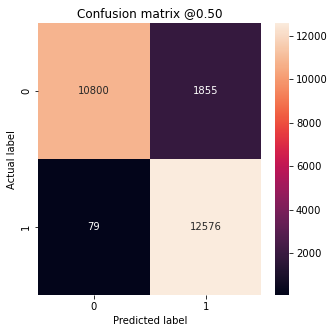

In [17]:
plot_cm(y_test_smt, knn_preds_smt)

# Optimize KNN Model

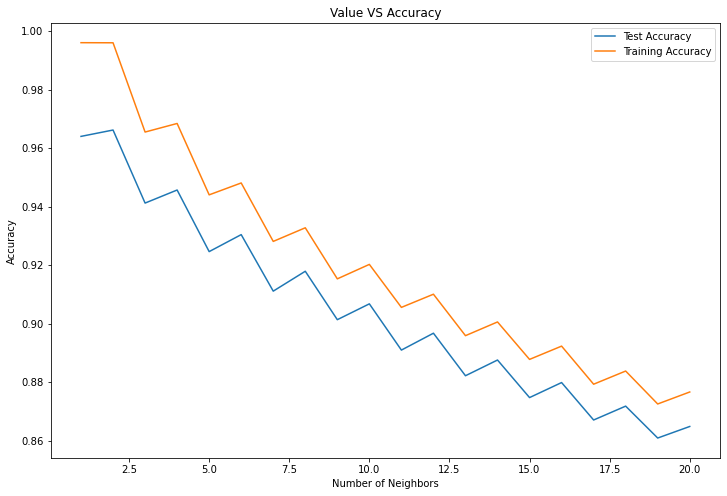

Best accuracy is 0.9661793757408139 with n = 2


In [40]:
# set range of n values
neighbor = range(1, 21)
train_acc = []
test_acc = []

# Loop through different values of n
for i, n in enumerate(neighbor):
    # n from 1 to 20
    knn_model = KNeighborsClassifier(n_neighbors=n)
    
    # Fit with knn
    knn_model.fit(X_train_smt,y_train_smt)
    
    # train accuracy
    train_acc.append(knn_model.score(X_train_smt, y_train_smt))
    
    # test accuracy
    test_acc.append(knn_model.score(X_test_smt, y_test_smt))

# line plot
plt.figure(figsize=[12, 8])
plt.plot(neighbor, test_acc, label = 'Test Accuracy')
plt.plot(neighbor, train_acc, label = 'Training Accuracy')
plt.legend()
plt.title('Value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
#plt.xticks(neig)
#plt.savefig('graph.png')
plt.show()

# print best score
print("Best accuracy is {} with n = {}".format(np.max(test_acc), 1+test_acc.index(np.max(test_acc))))

In [20]:
knn_model_imp = KNeighborsClassifier(n_neighbors=2)
knn_model_imp.fit(X_train_smt, y_train_smt)

knn_preds_smt_imp = knn_model_imp.predict(X_test_smt)
knn_preds_smt_imp = np.round(knn_preds_smt_imp)

#Display the classification report of the model out of prediction using the test data
print(classification_report(y_test_smt, knn_preds_smt_imp))

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     12655
           1       0.94      0.99      0.97     12655

    accuracy                           0.97     25310
   macro avg       0.97      0.97      0.97     25310
weighted avg       0.97      0.97      0.97     25310



Correct Non-injury predictions (True Negatives):  11874
Incorrect Non-injury predictions (False Positives):  781
Correct injury predictions (False Negatives):  77
Incorrect injury predictions (True Positives):  12578
Total injury predictions:  12655


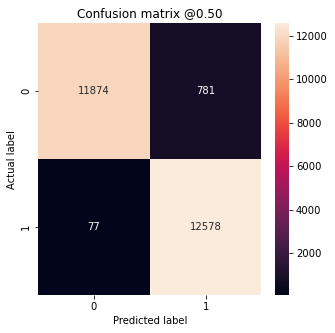

In [21]:
plot_cm(y_test_smt, knn_preds_smt_imp)